In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
paultimothymooney_chest_xray_pneumonia_path = kagglehub.dataset_download('paultimothymooney/chest-xray-pneumonia')

print('Data source import complete.')


Data source import complete.


# Introduction
Pneumonia remains one of the leading causes of morbidity and mortality among children worldwide, especially in developing countries. Accurate and timely diagnosis is crucial for effective treatment and improved patient outcomes. Traditionally, chest X-ray interpretation has relied on expert radiologists; however, this process is time-consuming, subject to inter-observer variability, and often limited by the availability of trained professionals.

Recent advances in deep learning have enabled automated analysis of medical images, offering the potential to assist clinicians in diagnosing pneumonia with high accuracy and speed. Convolutional Neural Networks (CNNs) are particularly well-suited for image classification tasks, as they can automatically learn complex hierarchical features from raw pixel data without manual feature engineering.

This notebook explores the application of PyTorch to develop a deep learning model capable of distinguishing between pneumonia and normal cases from pediatric chest X-ray images. The dataset consists of carefully curated images, graded by multiple medical experts to ensure quality and accuracy. Through detailed Exploratory Data Analysis (EDA), model training, evaluation, and prediction, the workflow demonstrates how AI can support medical decision-making in resource-limited settings.

![Pneumonia](https://media.gettyimages.com/id/1299730658/photo/medical-mri-scan.jpg?s=612x612&w=0&k=20&c=wF_feQEK_mMOXSKLfkrcIBGeHi5efnZrkV2PAyzADgk=)

# =============================
# Setup & Imports
# =============================

In [2]:
import os, random, time, json, math
from pathlib import Path
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image, ImageOps

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models, utils

from sklearn.metrics import (classification_report, confusion_matrix, roc_curve,
                             auc, precision_recall_curve, average_precision_score)
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# =============================
# Configuration
# =============================

In [3]:
class CFG:
    DATASET_ROOT = "paultimothymooney_chest_xray_pneumonia_path"  # change if needed
    ARTIFACTS = './artifacts'
    IMG_SIZE = 224
    BATCH_SIZE = 32
    NUM_WORKERS = 4
    EPOCHS = 20
    LR = 1e-4
    WD = 1e-4
    PATIENCE = 6
    PRETRAINED = True
    USE_AMP = True
    SEED = 42
    NUM_SAMPLES_FOR_STATS = 2000  # to speed up EDA stats on huge datasets

os.makedirs(CFG.ARTIFACTS, exist_ok=True)
random.seed(CFG.SEED); np.random.seed(CFG.SEED); torch.manual_seed(CFG.SEED); torch.cuda.manual_seed_all(CFG.SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)


Device: cuda


# =============================
# Utility functions
# =============================

In [4]:
def pil_open_rgb(path):
    img = Image.open(path)
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img


def save_df(df: pd.DataFrame, name: str):
    p = os.path.join(CFG.ARTIFACTS, name)
    df.to_csv(p, index=False)
    print('Saved ->', p)


def show_grid(images, titles=None, nrow=4, fname=None):
    grid = utils.make_grid(images, nrow=nrow, normalize=True, pad_value=1.0)
    npimg = grid.permute(1, 2, 0).cpu().numpy()
    plt.figure(figsize=(12, 12))
    plt.imshow(npimg)
    plt.axis('off')
    if titles is not None:
        plt.title('\n'.join(titles))
    if fname:
        plt.tight_layout(); plt.savefig(os.path.join(CFG.ARTIFACTS, fname), dpi=200)
        plt.close()
    else:
        plt.show()

# =============================
# Dataset & EDA
# =============================

In [5]:
import os
CFG.DATASET_ROOT = os.path.join(paultimothymooney_chest_xray_pneumonia_path, "chest_xray")

ROOT = Path(CFG.DATASET_ROOT)
assert ROOT.exists(), f"Dataset root not found: {ROOT}"
SPLITS = ['train', 'val', 'test']

# --- Class counts per split
counts = []
for split in SPLITS:
    split_path = ROOT / split
    if not split_path.exists():
        raise FileNotFoundError(f"Missing split folder: {split_path}")
    ds = datasets.ImageFolder(split_path)
    class_names = ds.classes
    c = Counter([label for _, label in ds.samples])
    for cls_idx, cls_name in enumerate(class_names):
        counts.append({'split': split, 'class': cls_name, 'count': c.get(cls_idx, 0)})

counts_df = pd.DataFrame(counts)
save_df(counts_df, 'class_counts_by_split.csv')

pd.read_csv('/kaggle/working/artifacts/class_counts_by_split.csv')

Saved -> ./artifacts/class_counts_by_split.csv


,split,class,count
0,train,NORMAL,1341
1,train,PNEUMONIA,3875
2,val,NORMAL,8
3,val,PNEUMONIA,8
4,test,NORMAL,234
5,test,PNEUMONIA,390


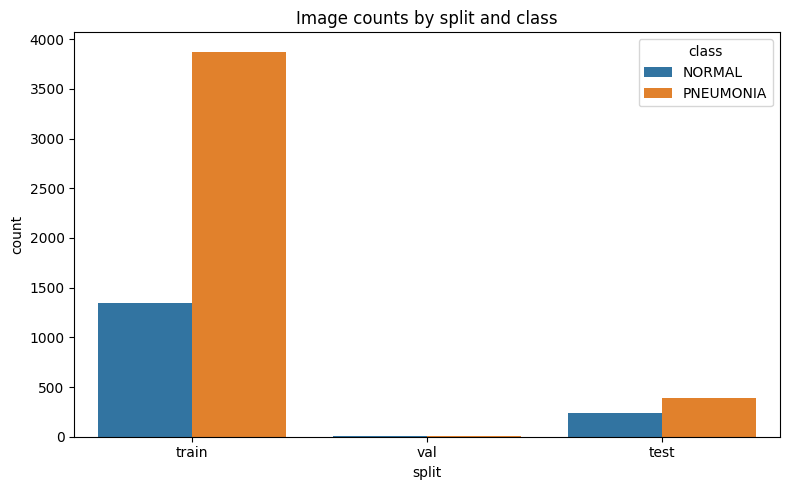

In [6]:
plt.figure(figsize=(8,5))
sns.barplot(data=counts_df, x='split', y='count', hue='class')
plt.title('Image counts by split and class')
plt.tight_layout()
plt.savefig(os.path.join(CFG.ARTIFACTS, 'class_counts_by_split.png'), dpi=200)
plt.show()
plt.close()

In [7]:
# --- Random sample grids from each split/class
for split in SPLITS:
    ds = datasets.ImageFolder(ROOT / split)
    idxs_by_class = defaultdict(list)
    for i, (_, y) in enumerate(ds.samples):
        idxs_by_class[y].append(i)
    for cls_idx, cls_name in enumerate(ds.classes):
        sel = random.sample(idxs_by_class[cls_idx], k=min(16, len(idxs_by_class[cls_idx]))) if idxs_by_class[cls_idx] else []
        if not sel: continue
        imgs = []
        for i in sel:
            path, _ = ds.samples[i]
            img = pil_open_rgb(path)
            img = transforms.functional.resize(img, [CFG.IMG_SIZE, CFG.IMG_SIZE])
            imgs.append(transforms.ToTensor()(img))
        if imgs:
            show_grid(torch.stack(imgs), nrow=4, fname=f'sample_grid_{split}_{cls_name}.png')

# --- Image size distribution & intensity histogram (sampled)
all_paths = []
for split in SPLITS:
    ds = datasets.ImageFolder(ROOT / split)
    all_paths += [p for (p, _) in ds.samples]
random.shuffle(all_paths)
sample_paths = all_paths[:min(CFG.NUM_SAMPLES_FOR_STATS, len(all_paths))]

sizes = []
intensities = []
for p in tqdm(sample_paths, desc='Scanning images for EDA'):
    img = Image.open(p)
    sizes.append(img.size)  # (W, H)
    g = ImageOps.grayscale(img)
    intensities.extend(np.array(g).flatten().tolist())

sizes_df = pd.DataFrame(sizes, columns=['width','height'])
save_df(sizes_df, 'image_sizes_sample.csv')

pd.read_csv('/kaggle/working/artifacts/image_sizes_sample.csv')

Scanning images for EDA: 100%|██████████| 2000/2000 [01:26<00:00, 23.14it/s]

Saved -> ./artifacts/image_sizes_sample.csv


,width,height
0,1576,1376
1,1168,776
2,529,207
3,1264,744
4,1568,1560
...,...,...
1995,760,440
1996,1272,1040
1997,1202,986
1998,1664,1264


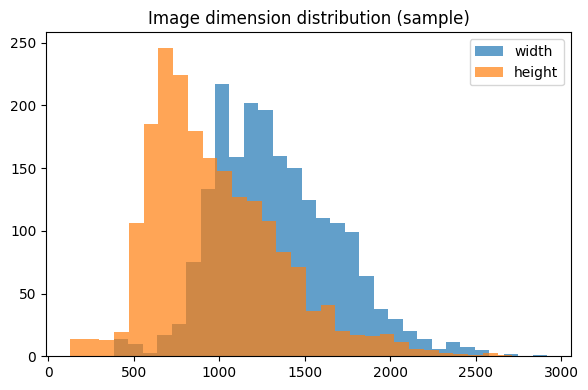

In [8]:
plt.figure(figsize=(6,4))
plt.hist(sizes_df['width'], bins=30, alpha=0.7, label='width')
plt.hist(sizes_df['height'], bins=30, alpha=0.7, label='height')
plt.legend(); plt.title('Image dimension distribution (sample)')
plt.tight_layout()
plt.savefig(os.path.join(CFG.ARTIFACTS, 'image_size_distribution.png'), dpi=200)
plt.show()
plt.close()

In [ ]:
# plt.figure(figsize=(6,4))
# plt.hist(intensities, bins=50)
# plt.title('Grayscale intensity histogram (sample)')
# plt.xlabel('Pixel value'); plt.ylabel('Frequency')
# plt.tight_layout()
# plt.savefig(os.path.join(CFG.ARTIFACTS, 'intensity_histogram.png'), dpi=200)
# plt.show()
# plt.close()

In [10]:
# --- Compute dataset channel mean/std on a sample via DataLoader
mean = torch.zeros(3); std = torch.zeros(3)
calc_tf = transforms.Compose([
    transforms.Resize((CFG.IMG_SIZE, CFG.IMG_SIZE)),
    transforms.ToTensor(),
])

class SimplePathsDataset(Dataset):
    def __init__(self, paths, transform=None):
        self.paths = paths; self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, idx):
        img = pil_open_rgb(self.paths[idx])
        if self.transform: img = self.transform(img)
        return img

stat_loader = DataLoader(SimplePathsDataset(sample_paths, calc_tf), batch_size=64, shuffle=False, num_workers=CFG.NUM_WORKERS)
nb_samples = 0
for x in stat_loader:
    bs = x.size(0)
    x = x.view(bs, 3, -1)
    mean += x.mean(2).sum(0)
    std += x.std(2).sum(0)
    nb_samples += bs
mean /= nb_samples; std /= nb_samples
print('Dataset sample mean:', mean.tolist(), 'std:', std.tolist())
with open(os.path.join(CFG.ARTIFACTS, 'dataset_mean_std.json'), 'w') as f:
    json.dump({'mean': mean.tolist(), 'std': std.tolist()}, f, indent=2)

Dataset sample mean: [0.4811384379863739, 0.4811384379863739, 0.4811384379863739] std: [0.22127097845077515, 0.22127097845077515, 0.22127097845077515]


# =============================
# Data Transforms & Dataloaders
# =============================

In [11]:
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(CFG.IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist()),
])
val_tf = transforms.Compose([
    transforms.Resize(int(CFG.IMG_SIZE*1.1)),
    transforms.CenterCrop(CFG.IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist()),
])
train_ds = datasets.ImageFolder(ROOT/'train', transform=train_tf)
val_ds   = datasets.ImageFolder(ROOT/'val',   transform=val_tf)
test_ds  = datasets.ImageFolder(ROOT/'test',  transform=val_tf)

classes = train_ds.classes
assert classes == val_ds.classes == test_ds.classes, 'Class mismatch across splits'

train_loader = DataLoader(train_ds, batch_size=CFG.BATCH_SIZE, shuffle=True,  num_workers=CFG.NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=CFG.BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS, pin_memory=True)

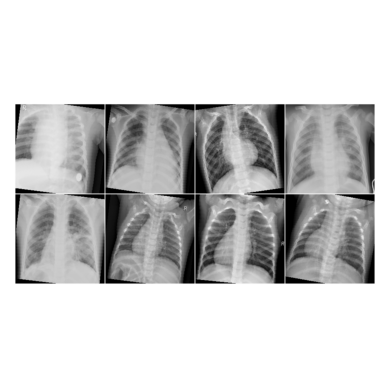

In [12]:
import random
import matplotlib.pyplot as plt
from PIL import Image

# --- Preview augmentations
preview_imgs = []
for i in range(8):
    path, label = train_ds.samples[random.randint(0, len(train_ds.samples)-1)]
    img = pil_open_rgb(path)
    timg = train_tf(img)
    preview_imgs.append(timg)

# Save grid
show_grid(torch.stack(preview_imgs), nrow=4, fname='augment_preview.png')

# Display in notebook
img = Image.open('/kaggle/working/artifacts/augment_preview.png')
plt.imshow(img)
plt.axis('off')
plt.show()


# =============================
# Model: ResNet-50 with custom head
# =============================

In [13]:
class PneumoResNet50(nn.Module):
    def __init__(self, num_classes=2, pretrained=True):
        super().__init__()
        self.backbone = models.resnet50(pretrained=pretrained)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.backbone(x)

model = PneumoResNet50(num_classes=len(classes), pretrained=CFG.PRETRAINED).to(device)
print(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 194MB/s] 


PneumoResNet50(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
  

In [14]:
# Class weights for imbalance
train_labels = [y for (_, y) in train_ds.samples]
class_counts = Counter(train_labels)
weights = torch.tensor([1.0/class_counts[i] for i in range(len(classes))], dtype=torch.float32)
weights = weights / weights.mean()
weights = weights.to(device)
print('Class weights:', weights)

criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.AdamW(model.parameters(), lr=CFG.LR, weight_decay=CFG.WD)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)
scaler = torch.cuda.amp.GradScaler(enabled=CFG.USE_AMP)

Class weights: tensor([1.4858, 0.5142], device='cuda:0')


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_36/1951481831.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=CFG.USE_AMP)


# =============================
# Training & Validation
# =============================

In [15]:
def eval_epoch(model, loader):
    model.eval()
    total, correct = 0, 0
    losses = []
    all_probs, all_labels = [], []
    with torch.no_grad():
        for x, y in tqdm(loader, desc='Eval', leave=False):
            x, y = x.to(device), y.to(device)
            with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):
                logits = model(x)
                loss = criterion(logits, y)
            probs = torch.softmax(logits, dim=1)[:,1]
            pred = logits.argmax(1)
            correct += (pred==y).sum().item(); total += y.size(0)
            losses.append(loss.item()*y.size(0))
            all_probs.extend(probs.detach().cpu().numpy().tolist())
            all_labels.extend(y.detach().cpu().numpy().tolist())
    acc = correct/total
    avg_loss = np.sum(losses)/total
    return avg_loss, acc, np.array(all_probs), np.array(all_labels)

best_val_metric = -1
history = []
ckpt_path = os.path.join(CFG.ARTIFACTS, 'best_model.pth')

In [16]:
for epoch in range(1, CFG.EPOCHS+1):
    print(f"Epoch {epoch}/{CFG.EPOCHS}")
    # Train
    model.train()
    t0 = time.time()
    running_loss, running_corrects, total = 0.0, 0, 0
    for x, y in tqdm(train_loader, desc='Train', leave=False):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        preds = logits.argmax(1)
        running_loss += loss.item()*y.size(0)
        running_corrects += (preds==y).sum().item()
        total += y.size(0)
    train_loss = running_loss/total
    train_acc = running_corrects/total

    # Validate
    val_loss, val_acc, val_probs, val_labels = eval_epoch(model, val_loader)

    # AUC on validation
    fpr, tpr, _ = roc_curve(val_labels, val_probs)
    val_auc = auc(fpr, tpr)
    scheduler.step(val_auc)

    elapsed = time.time()-t0
    print(f"train_loss={train_loss:.4f} acc={train_acc:.4f} | val_loss={val_loss:.4f} acc={val_acc:.4f} auc={val_auc:.4f} | {elapsed:.1f}s")

    history.append({'epoch': epoch, 'train_loss': train_loss, 'train_acc': train_acc,
                    'val_loss': val_loss, 'val_acc': val_acc, 'val_auc': val_auc,
                    'lr': optimizer.param_groups[0]['lr']})

    # checkpoint
    if val_auc > best_val_metric:
        best_val_metric = val_auc
        torch.save({'epoch': epoch, 'model': model.state_dict(), 'val_auc': val_auc}, ckpt_path)
        print('Saved best model ->', ckpt_path)

# Save history
hist_df = pd.DataFrame(history)
save_df(hist_df, 'training_history.csv')

Epoch 1/20


Train:   0%|          | 0/163 [00:00<?, ?it/s]/tmp/ipykernel_36/1320945190.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):
Eval:   0%|          | 0/1 [00:00<?, ?it/s]             /tmp/ipykernel_36/6440601.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):


train_loss=0.1721 acc=0.9390 | val_loss=0.8892 acc=0.5000 auc=1.0000 | 52.6s
Saved best model -> ./artifacts/best_model.pth
Epoch 2/20


Train:   0%|          | 0/163 [00:00<?, ?it/s]/tmp/ipykernel_36/1320945190.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):
Eval:   0%|          | 0/1 [00:00<?, ?it/s]             /tmp/ipykernel_36/6440601.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):


train_loss=0.0982 acc=0.9688 | val_loss=0.3170 acc=0.8125 auc=0.9688 | 47.9s
Epoch 3/20


Train:   0%|          | 0/163 [00:00<?, ?it/s]/tmp/ipykernel_36/1320945190.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):
Eval:   0%|          | 0/1 [00:00<?, ?it/s]             /tmp/ipykernel_36/6440601.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):


train_loss=0.0831 acc=0.9728 | val_loss=0.5722 acc=0.8750 auc=1.0000 | 47.1s
Epoch 4/20


Train:   0%|          | 0/163 [00:00<?, ?it/s]/tmp/ipykernel_36/1320945190.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):
Eval:   0%|          | 0/1 [00:00<?, ?it/s]             /tmp/ipykernel_36/6440601.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):


train_loss=0.0754 acc=0.9757 | val_loss=0.3641 acc=0.8750 auc=1.0000 | 45.5s
Epoch 5/20


Train:   0%|          | 0/163 [00:00<?, ?it/s]/tmp/ipykernel_36/1320945190.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):
Eval:   0%|          | 0/1 [00:00<?, ?it/s]             /tmp/ipykernel_36/6440601.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):


train_loss=0.0572 acc=0.9816 | val_loss=0.4239 acc=0.8750 auc=1.0000 | 46.1s
Epoch 6/20


Train:   0%|          | 0/163 [00:00<?, ?it/s]/tmp/ipykernel_36/1320945190.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):
Eval:   0%|          | 0/1 [00:00<?, ?it/s]             /tmp/ipykernel_36/6440601.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):


train_loss=0.0492 acc=0.9833 | val_loss=0.4484 acc=0.8750 auc=1.0000 | 48.2s
Epoch 7/20


Train:   0%|          | 0/163 [00:00<?, ?it/s]/tmp/ipykernel_36/1320945190.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):
Eval:   0%|          | 0/1 [00:00<?, ?it/s]             /tmp/ipykernel_36/6440601.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):


train_loss=0.0470 acc=0.9852 | val_loss=1.3029 acc=0.6250 auc=0.9688 | 48.1s
Epoch 8/20


Train:   0%|          | 0/163 [00:00<?, ?it/s]/tmp/ipykernel_36/1320945190.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):
Eval:   0%|          | 0/1 [00:00<?, ?it/s]             /tmp/ipykernel_36/6440601.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):


train_loss=0.0331 acc=0.9887 | val_loss=0.5343 acc=0.8125 auc=1.0000 | 47.9s
Epoch 9/20


Train:   0%|          | 0/163 [00:00<?, ?it/s]/tmp/ipykernel_36/1320945190.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):
Eval:   0%|          | 0/1 [00:00<?, ?it/s]             /tmp/ipykernel_36/6440601.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):


train_loss=0.0334 acc=0.9893 | val_loss=0.8324 acc=0.7500 auc=1.0000 | 47.9s
Epoch 10/20


Train:   0%|          | 0/163 [00:00<?, ?it/s]/tmp/ipykernel_36/1320945190.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):
Eval:   0%|          | 0/1 [00:00<?, ?it/s]             /tmp/ipykernel_36/6440601.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):


train_loss=0.0320 acc=0.9881 | val_loss=1.1054 acc=0.7500 auc=1.0000 | 48.7s
Epoch 11/20


Train:   0%|          | 0/163 [00:00<?, ?it/s]/tmp/ipykernel_36/1320945190.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):
Eval:   0%|          | 0/1 [00:00<?, ?it/s]             /tmp/ipykernel_36/6440601.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):


train_loss=0.0209 acc=0.9941 | val_loss=0.6058 acc=0.8750 auc=0.9844 | 47.9s
Epoch 12/20


Train:   0%|          | 0/163 [00:00<?, ?it/s]/tmp/ipykernel_36/1320945190.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):
Eval:   0%|          | 0/1 [00:00<?, ?it/s]             /tmp/ipykernel_36/6440601.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):


train_loss=0.0217 acc=0.9929 | val_loss=0.6102 acc=0.8125 auc=1.0000 | 48.1s
Epoch 13/20


Train:   0%|          | 0/163 [00:00<?, ?it/s]/tmp/ipykernel_36/1320945190.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):
Eval:   0%|          | 0/1 [00:00<?, ?it/s]             /tmp/ipykernel_36/6440601.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):


train_loss=0.0168 acc=0.9954 | val_loss=0.5750 acc=0.7500 auc=1.0000 | 47.9s
Epoch 14/20


Train:   0%|          | 0/163 [00:00<?, ?it/s]/tmp/ipykernel_36/1320945190.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):
Eval:   0%|          | 0/1 [00:00<?, ?it/s]             /tmp/ipykernel_36/6440601.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):


train_loss=0.0179 acc=0.9954 | val_loss=0.6876 acc=0.8125 auc=1.0000 | 48.0s
Epoch 15/20


Train:   0%|          | 0/163 [00:00<?, ?it/s]/tmp/ipykernel_36/1320945190.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):
Eval:   0%|          | 0/1 [00:00<?, ?it/s]             /tmp/ipykernel_36/6440601.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):


train_loss=0.0175 acc=0.9948 | val_loss=0.8657 acc=0.7500 auc=1.0000 | 48.3s
Epoch 16/20


Train:   0%|          | 0/163 [00:00<?, ?it/s]/tmp/ipykernel_36/1320945190.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):
Eval:   0%|          | 0/1 [00:00<?, ?it/s]             /tmp/ipykernel_36/6440601.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):


train_loss=0.0153 acc=0.9965 | val_loss=1.0544 acc=0.7500 auc=1.0000 | 45.7s
Epoch 17/20


Train:   0%|          | 0/163 [00:00<?, ?it/s]/tmp/ipykernel_36/1320945190.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):
Eval:   0%|          | 0/1 [00:00<?, ?it/s]             /tmp/ipykernel_36/6440601.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):


train_loss=0.0105 acc=0.9979 | val_loss=0.6905 acc=0.7500 auc=1.0000 | 46.9s
Epoch 18/20


Train:   0%|          | 0/163 [00:00<?, ?it/s]/tmp/ipykernel_36/1320945190.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):
Eval:   0%|          | 0/1 [00:00<?, ?it/s]             /tmp/ipykernel_36/6440601.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):


train_loss=0.0113 acc=0.9969 | val_loss=0.7304 acc=0.7500 auc=1.0000 | 46.2s
Epoch 19/20


Train:   0%|          | 0/163 [00:00<?, ?it/s]/tmp/ipykernel_36/1320945190.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):
Eval:   0%|          | 0/1 [00:00<?, ?it/s]             /tmp/ipykernel_36/6440601.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):


train_loss=0.0105 acc=0.9971 | val_loss=0.9380 acc=0.7500 auc=1.0000 | 48.2s
Epoch 20/20


Train:   0%|          | 0/163 [00:00<?, ?it/s]/tmp/ipykernel_36/1320945190.py:10: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):
Eval:   0%|          | 0/1 [00:00<?, ?it/s]             /tmp/ipykernel_36/6440601.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):
                                                   

train_loss=0.0090 acc=0.9975 | val_loss=0.8638 acc=0.7500 auc=1.0000 | 47.9s
Saved -> ./artifacts/training_history.csv


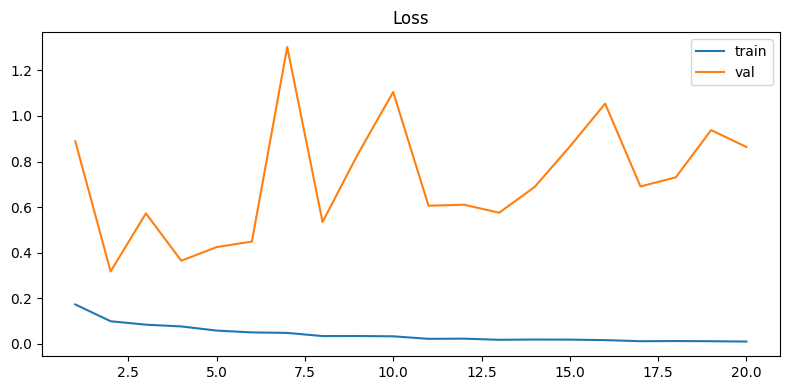

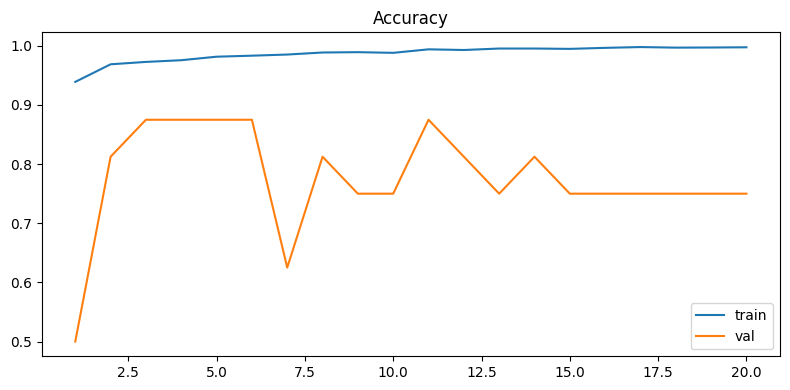

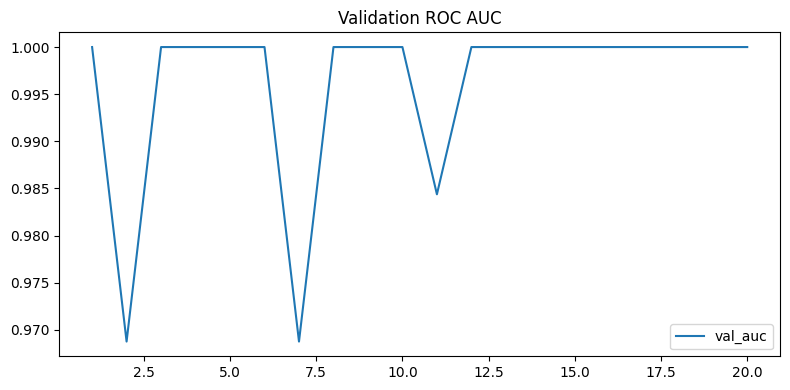

In [17]:
plt.figure(figsize=(8,4)); plt.plot(hist_df['epoch'], hist_df['train_loss'], label='train'); plt.plot(hist_df['epoch'], hist_df['val_loss'], label='val'); plt.legend(); plt.title('Loss'); plt.tight_layout(); plt.savefig(os.path.join(CFG.ARTIFACTS, 'loss_curve.png'), dpi=200); plt.show(); plt.close()
plt.figure(figsize=(8,4)); plt.plot(hist_df['epoch'], hist_df['train_acc'], label='train'); plt.plot(hist_df['epoch'], hist_df['val_acc'], label='val'); plt.legend(); plt.title('Accuracy'); plt.tight_layout(); plt.savefig(os.path.join(CFG.ARTIFACTS, 'acc_curve.png'), dpi=200); plt.show(); plt.close()
plt.figure(figsize=(8,4)); plt.plot(hist_df['epoch'], hist_df['val_auc'], label='val_auc'); plt.legend(); plt.title('Validation ROC AUC'); plt.tight_layout(); plt.savefig(os.path.join(CFG.ARTIFACTS, 'val_auc_curve.png'), dpi=200); plt.show(); plt.close()

# =============================
# Test Evaluation
# =============================

In [18]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report

# --- Load best checkpoint (trusting the source, so set weights_only=False)
state = torch.load(ckpt_path, map_location=device, weights_only=False)
model.load_state_dict(state['model'])

# --- Test evaluation
model.eval()
all_probs, all_labels, all_preds = [], [], []
losses, total = [], 0

with torch.no_grad():
    for x, y in tqdm(test_loader, desc='Test', leave=False):
        x, y = x.to(device), y.to(device)
        with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):
            logits = model(x)
            loss = criterion(logits, y)

        probs = torch.softmax(logits, dim=1)[:, 1]  # probability of class 1
        preds = logits.argmax(1)

        # Accumulate results
        losses.append(loss.item() * y.size(0))
        total += y.size(0)
        all_probs.extend(probs.cpu().numpy())
        all_labels.extend(y.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# --- Metrics
all_probs = np.array(all_probs)
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

cm = confusion_matrix(all_labels, all_preds)
report = classification_report(all_labels, all_preds, target_names=classes, output_dict=True)

# --- Save classification report
report_df = pd.DataFrame(report).transpose()
report_df.to_csv('classification_report.csv', index=True)

# --- Display saved report
pd.read_csv('classification_report.csv')


Test:   0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_36/4220016599.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=CFG.USE_AMP):


,Unnamed: 0,precision,recall,f1-score,support
0,NORMAL,0.980000,0.418803,0.586826,234.000000
1,PNEUMONIA,0.740458,0.994872,0.849015,390.000000
2,accuracy,0.778846,0.778846,0.778846,0.778846
3,macro avg,0.860229,0.706838,0.717921,624.000000
4,weighted avg,0.830286,0.778846,0.750694,624.000000


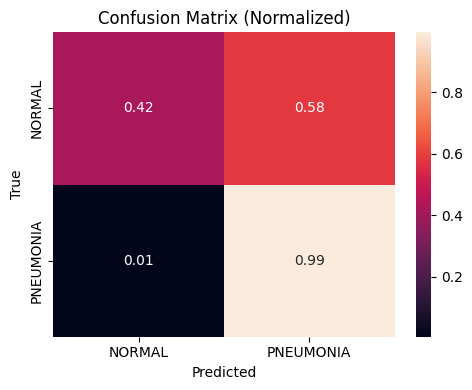

In [19]:
# confusion matrix plot (normalized)
cm_norm = cm.astype(float)/cm.sum(axis=1, keepdims=True)
plt.figure(figsize=(5,4)); sns.heatmap(cm_norm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix (Normalized)')
plt.tight_layout(); plt.savefig(os.path.join(CFG.ARTIFACTS, 'confusion_matrix.png'), dpi=200); plt.show(); plt.close()

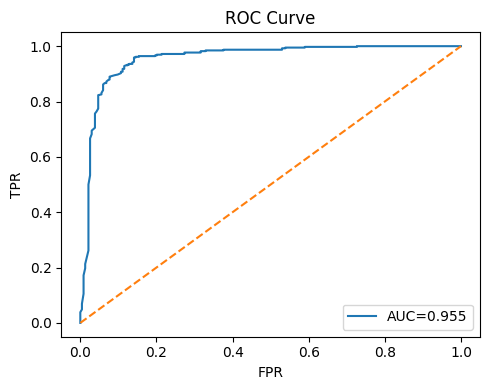

In [19]:
# ROC curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(5,4)); plt.plot(fpr, tpr, label=f'AUC={roc_auc:.3f}'); plt.plot([0,1],[0,1],'--'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend()
plt.tight_layout(); plt.savefig(os.path.join(CFG.ARTIFACTS, 'roc_curve.png'), dpi=200); plt.show(); plt.close()

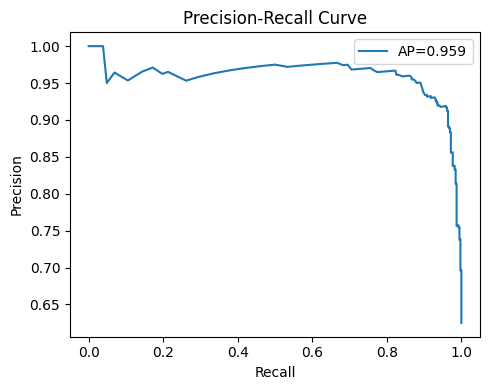

In [20]:
# Precision-Recall curve
prec, rec, _ = precision_recall_curve(all_labels, all_probs)
ap = average_precision_score(all_labels, all_probs)
plt.figure(figsize=(5,4)); plt.plot(rec, prec, label=f'AP={ap:.3f}'); plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve'); plt.legend()
plt.tight_layout(); plt.savefig(os.path.join(CFG.ARTIFACTS, 'pr_curve.png'), dpi=200); plt.show(); plt.close()

# =============================
# Grad-CAM (qualitative)
# =============================

#### Grad-CAM Visualization Code Overview
This section of code is:

Implementing a Grad-CAM utility that hooks into the chosen convolutional layer to capture both the feature maps from the forward pass and the gradients from the backward pass.

Using those gradients to weight the activations, producing a heatmap that highlights image regions most responsible for a particular prediction.

Selecting a handful of test images at random, running them through the model, generating their Grad-CAM heatmaps, and overlaying those heatmaps onto the original images.

Saving side-by-side visual comparisons (original vs. Grad-CAM overlay) to a designated artifacts directory for later review.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


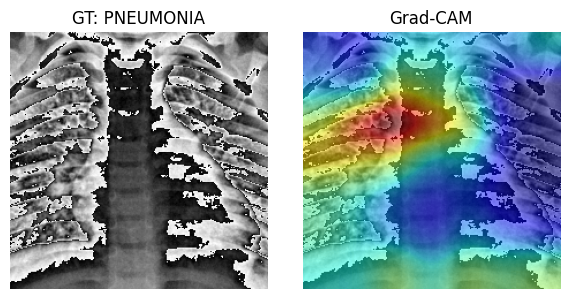

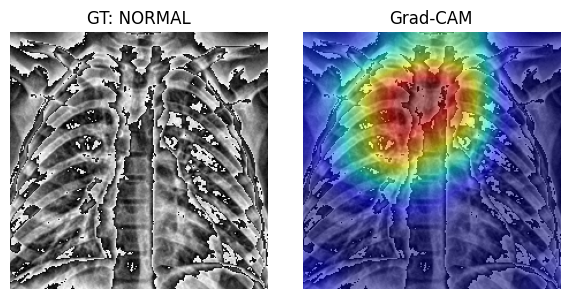

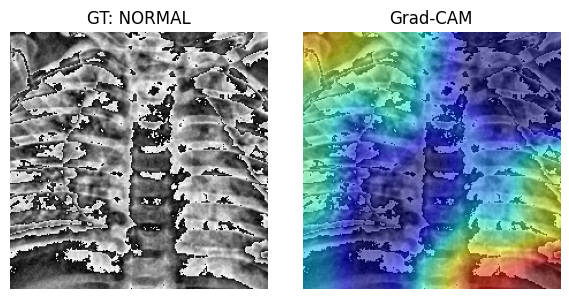

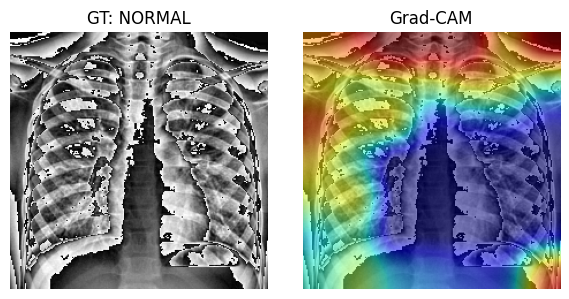

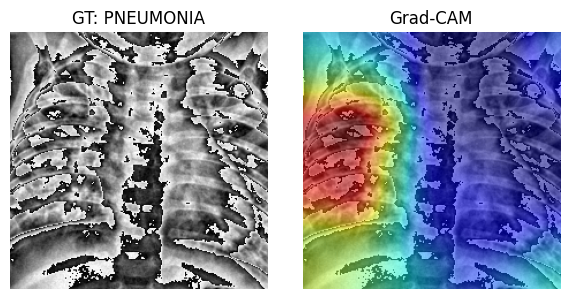

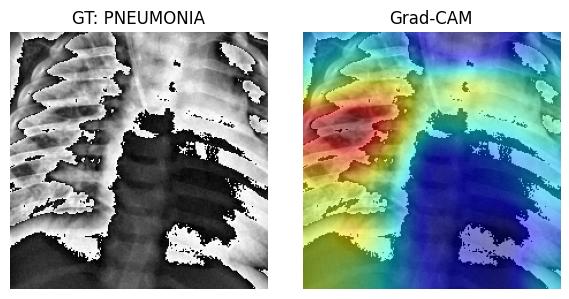

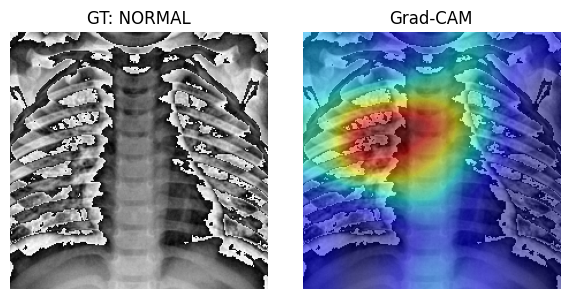

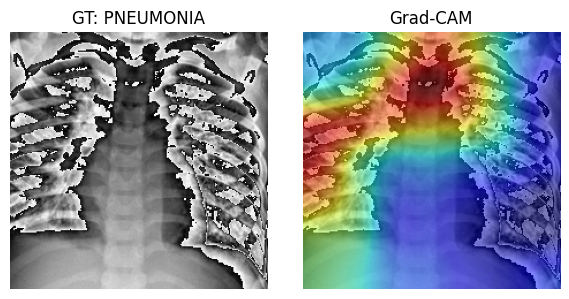

In [21]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model; self.model.eval()
        self.gradients = None; self.activations = None
        def fwd_hook(m, i, o): self.activations = o.detach()
        def bwd_hook(m, gi, go): self.gradients = go[0].detach()
        target_layer.register_forward_hook(fwd_hook)
        target_layer.register_backward_hook(bwd_hook)
    def generate(self, x, class_idx=None):
        self.model.zero_grad()
        out = self.model(x)
        if class_idx is None:
            class_idx = out.argmax(1).item()
        loss = out[0, class_idx]
        loss.backward(retain_graph=True)
        grads = self.gradients[0]  # C,H,W
        acts = self.activations[0]
        weights = grads.mean(dim=(1,2))
        cam = torch.zeros(acts.shape[1:], dtype=torch.float32, device=acts.device)
        for i, w in enumerate(weights): cam += w*acts[i]
        cam = torch.relu(cam)
        cam = (cam - cam.min())/(cam.max()-cam.min() + 1e-6)
        return cam.detach().cpu().numpy()

os.makedirs(os.path.join(CFG.ARTIFACTS, 'gradcam'), exist_ok=True)
# last convolutional block of ResNet-50
target_layer = model.backbone.layer4[-1].conv3
cam_engine = GradCAM(model, target_layer)

# pick some test samples
indices = random.sample(range(len(test_ds)), k=min(8, len(test_ds)))
for i, idx in enumerate(indices):
    path, label = test_ds.samples[idx]
    img = pil_open_rgb(path)
    inp = val_tf(img).unsqueeze(0).to(device)
    cam = cam_engine.generate(inp)
    # overlay
    base = transforms.ToPILImage()(val_tf(img))
    heat = Image.fromarray(np.uint8(255*cam)).resize(base.size)
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1); plt.imshow(base); plt.axis('off'); plt.title(f'GT: {classes[label]}')
    plt.subplot(1,2,2); plt.imshow(base); plt.imshow(heat, cmap='jet', alpha=0.5); plt.axis('off'); plt.title('Grad-CAM')
    plt.tight_layout(); plt.savefig(os.path.join(CFG.ARTIFACTS, 'gradcam', f'cam_{i}.png'), dpi=200); plt.show(); plt.close()


# =============================
# Inference Utilities (single image or folder)
# =============================

In [29]:
test_image_path = os.path.join(CFG.DATASET_ROOT, 'test', 'NORMAL', 'IM-0001-0001.jpeg')
INV_NORM = transforms.Normalize(
    mean=[-m/s for m,s in zip(mean.tolist(), std.tolist())],
    std=[1/s for s in std.tolist()]
)

def predict_image(image_path: str):
    model.eval()
    img = pil_open_rgb(image_path)
    x = val_tf(img).unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(x)
        probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
        pred_idx = int(np.argmax(probs))
        return {'path': image_path, 'pred': classes[pred_idx], 'prob_normal': float(probs[0]), 'prob_pneumonia': float(probs[1])}


result = predict_image(test_image_path)
print(result)

{'path': '/kaggle/input/chest_xray/test/NORMAL/IM-0001-0001.jpeg', 'pred': 'PNEUMONIA', 'prob_normal': 0.4686131775379181, 'prob_pneumonia': 0.5313868522644043}


### If this notebook was helpful or interesting, consider giving it an upvote to support the work 🤓